In [21]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from prophet import Prophet
import matplotlib.pyplot as plt
import itertools


In [22]:
# Fetch data
market_data = pd.read_csv('sap500.csv')

market_data['Date'] = pd.to_datetime(market_data['Date'])

market_data = market_data.sort_values(by='Date')  # Sort by Date if not already sorted

In [23]:
market_data.head()

,Date,Open,High,Low,Close,Volume
0,1927-12-30,17.660000,17.660000,17.660000,17.660000,0
1,1928-01-03,17.760000,17.760000,17.760000,17.760000,0
2,1928-01-04,17.719999,17.719999,17.719999,17.719999,0
3,1928-01-05,17.549999,17.549999,17.549999,17.549999,0
4,1928-01-06,17.660000,17.660000,17.660000,17.660000,0


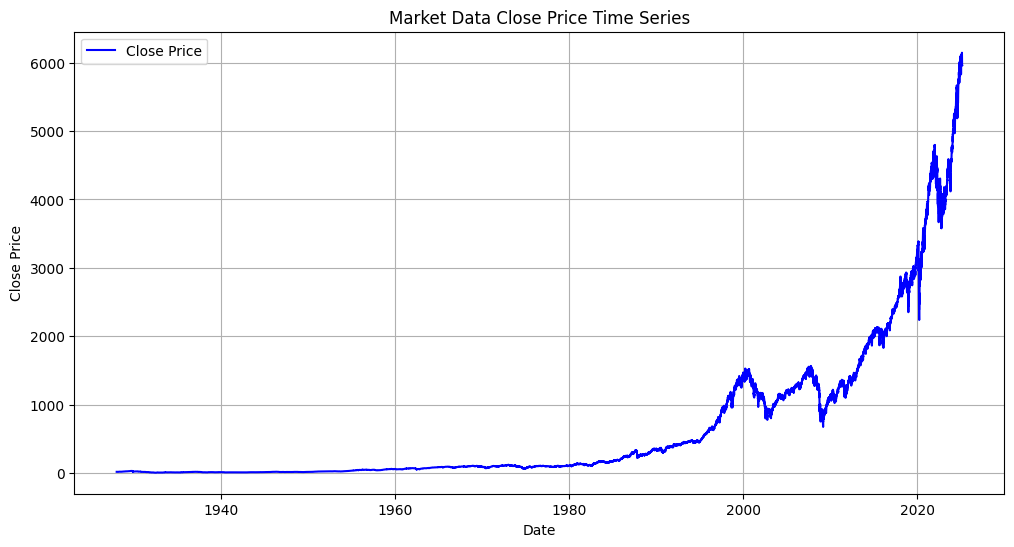

In [24]:
# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(market_data['Date'], market_data['Close'], label="Close Price", color='b')

# Formatting the plot
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("Market Data Close Price Time Series")
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

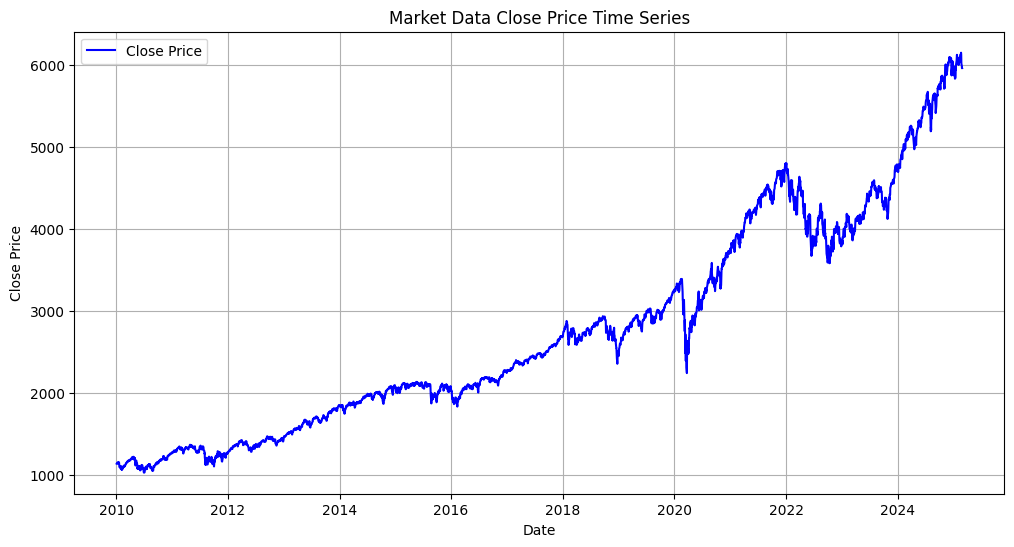

In [25]:
market_data = market_data[market_data['Date'] >= '2010-01-01']

# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(market_data['Date'], market_data['Close'], label="Close Price", color='b')

# Formatting the plot
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("Market Data Close Price Time Series")
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

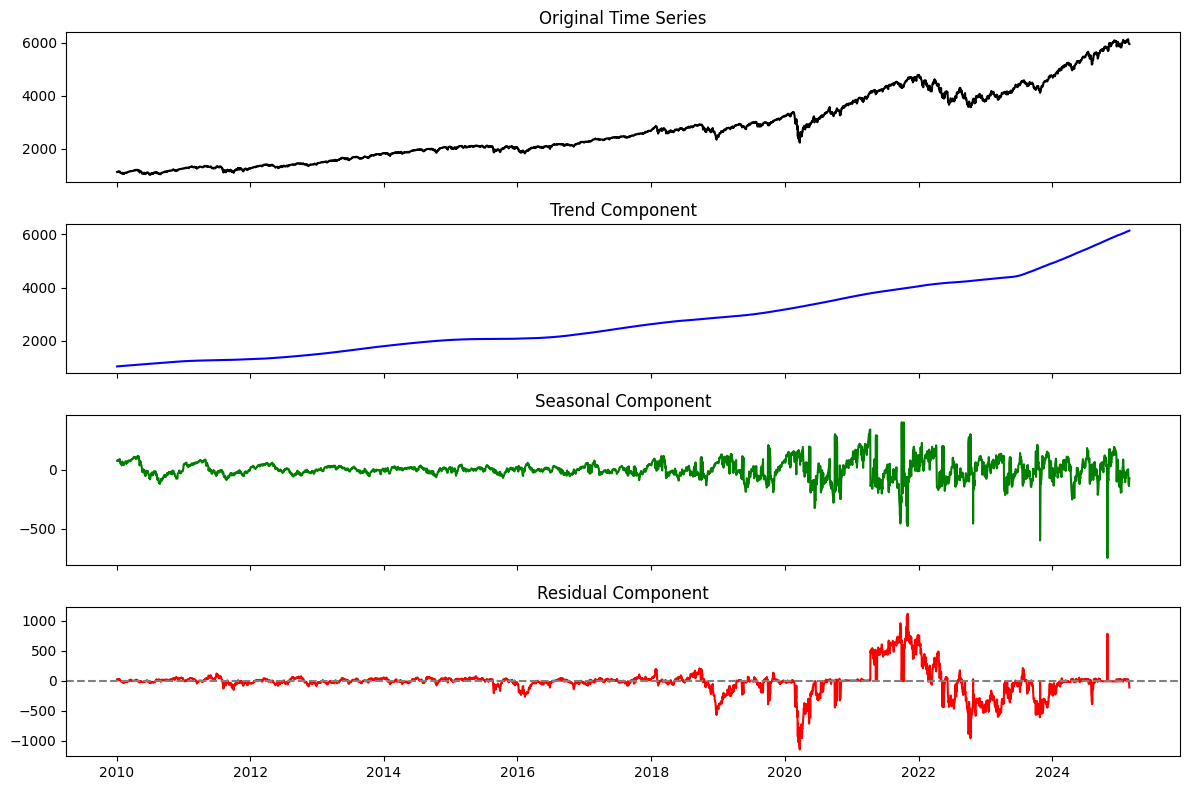

In [26]:
market_data.set_index('Date', inplace=True)

# Ensure period is set (252 trading days in a year)
stl = STL(market_data['Close'], period=252, robust=True)  
result = stl.fit()

# Plot the decomposition
fig, axs = plt.subplots(4, 1, figsize=(12, 8), sharex=True)

axs[0].plot(market_data.index, market_data['Close'], color='black', label="Original")
axs[0].set_title("Original Time Series")

axs[1].plot(market_data.index, result.trend, color='blue', label="Trend")
axs[1].set_title("Trend Component")

axs[2].plot(market_data.index, result.seasonal, color='green', label="Seasonal")
axs[2].set_title("Seasonal Component")

axs[3].plot(market_data.index, result.resid, color='red', label="Residual")
axs[3].set_title("Residual Component")
axs[3].axhline(0, linestyle='--', color='gray')

# Formatting
plt.tight_layout()
plt.show()

ADF Test for Original Close Price
ADF Statistic: 1.2858702965460014
p-value: 0.9965286390705728
Critical Values: {'1%': np.float64(-3.4320797760427144), '5%': np.float64(-2.862304319856036), '10%': np.float64(-2.5671768576612166)}
The series is non-stationary (fail to reject H0).
--------------------------------------------------
ADF Test for Differenced Close Price
ADF Statistic: -13.06848172668568
p-value: 1.9795553557146988e-24
Critical Values: {'1%': np.float64(-3.4320797760427144), '5%': np.float64(-2.862304319856036), '10%': np.float64(-2.5671768576612166)}
The series is stationary (reject H0).
--------------------------------------------------


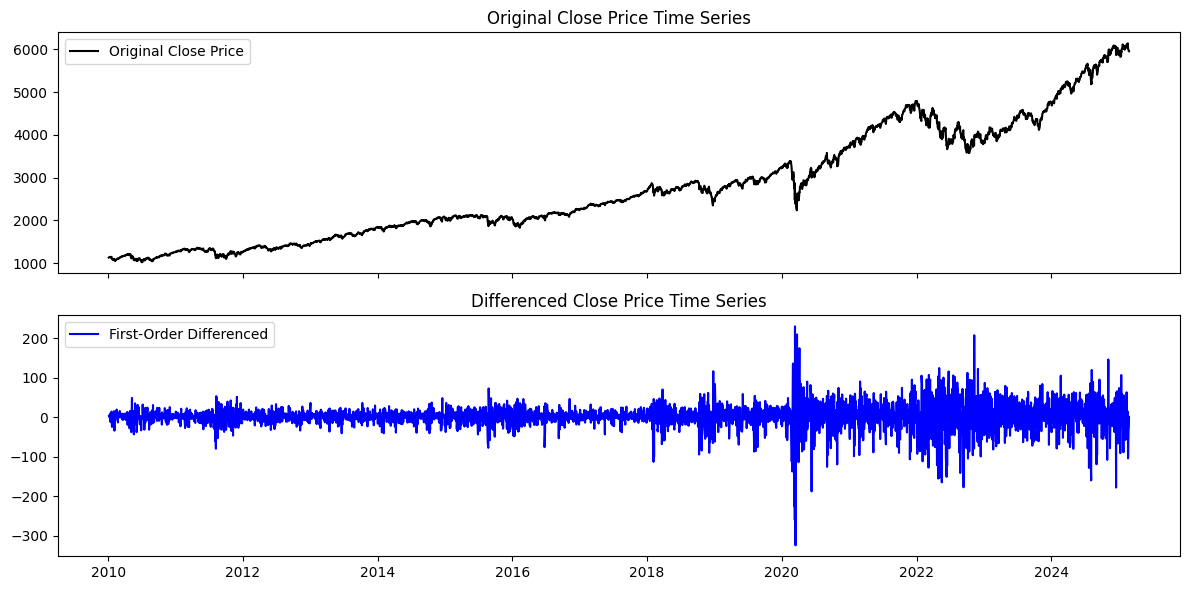

In [27]:
# ADF test function
def adf_test(series, title=""):
    result = adfuller(series.dropna())  # Drop NaN values for differenced series
    print(f"ADF Test for {title}")
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print("Critical Values:", result[4])
    if result[1] <= 0.05:
        print("The series is stationary (reject H0).")
    else:
        print("The series is non-stationary (fail to reject H0).")
    print("-" * 50)

# Perform ADF test on original Close price
adf_test(market_data['Close'], title="Original Close Price")

# Apply first-order differencing
market_data['Close_diff'] = market_data['Close'].diff()

# Perform ADF test on differenced data
adf_test(market_data['Close_diff'], title="Differenced Close Price")

# Plot the original and differenced series
fig, axs = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

axs[0].plot(market_data.index, market_data['Close'], color='black', label="Original Close Price")
axs[0].set_title("Original Close Price Time Series")
axs[0].legend()

axs[1].plot(market_data.index, market_data['Close_diff'], color='blue', label="First-Order Differenced")
axs[1].set_title("Differenced Close Price Time Series")
axs[1].legend()

plt.tight_layout()
plt.show()


ACF Values:
 [ 1.         -0.0742479   0.04382735 -0.02646823 -0.03911879  0.00818967
 -0.06730855  0.09528049 -0.08152635  0.10268567 -0.05691066  0.01499767
 -0.00238062 -0.03380372  0.02452732 -0.06333543  0.02386515 -0.02512395
  0.04584125 -0.00804944  0.00295472  0.03646224 -0.07137932 -0.003633
 -0.00384505 -0.03979572 -0.03614847  0.03753575 -0.0018693   0.00177747
 -0.02065336 -0.01579162 -0.01743787  0.00898725  0.01500466  0.01185559
  0.02639562 -0.0223305   0.00505953 -0.00829029 -0.01142827 -0.04356304
  0.03146776 -0.01741946 -0.01282595  0.03407754 -0.03180348  0.03802326
 -0.02035469 -0.00932695  0.00535185]

PACF Values:
 [ 1.00000000e+00 -7.42673960e-02  3.85473316e-02 -2.06395040e-02
 -4.45189676e-02  4.20117425e-03 -6.42970973e-02  8.46506293e-02
 -6.70011925e-02  8.57907630e-02 -4.29231548e-02  8.08636823e-03
 -4.81602946e-03 -1.86819650e-02  1.84287393e-03 -3.77535620e-02
 -9.98816213e-03 -1.31888666e-03  2.72671109e-02  4.07228450e-04
  1.87526702e-03  2.8967782

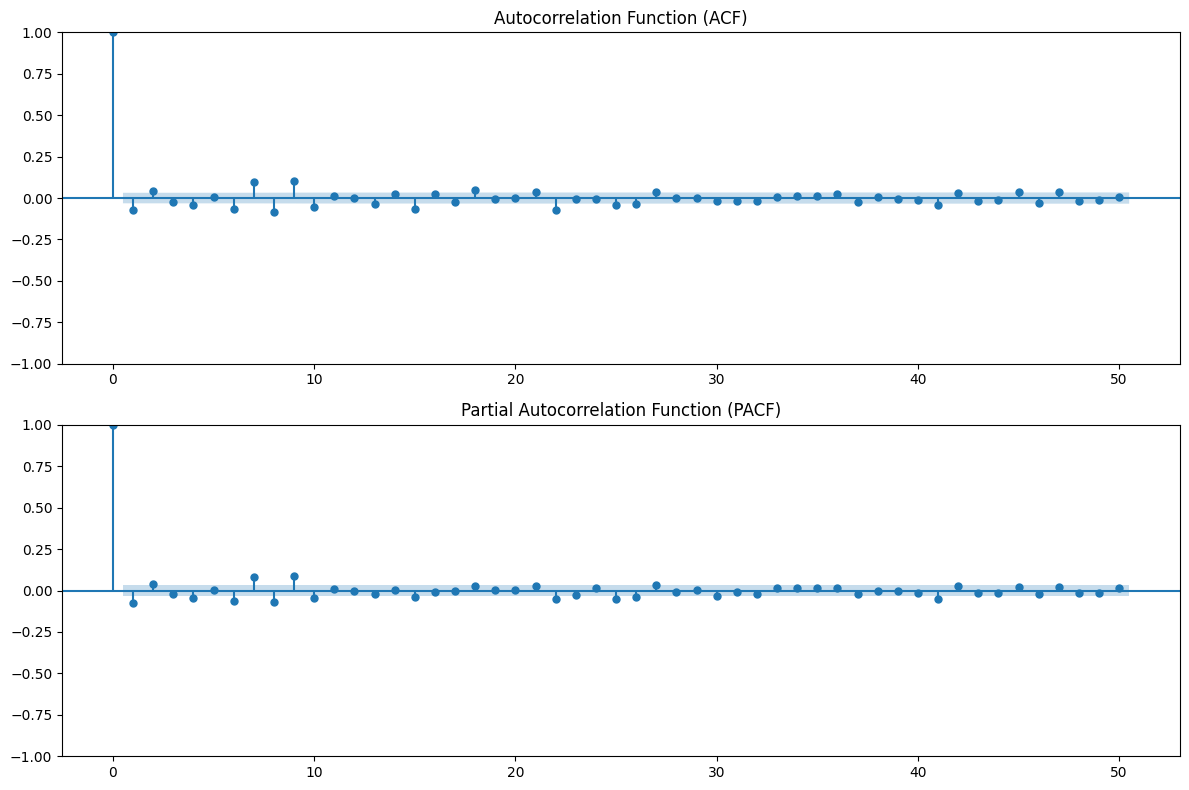

In [28]:
# First-order differencing to make the series stationary
market_data['Close_diff'] = market_data['Close'].diff().dropna()

# Calculate ACF and PACF values
acf_values = acf(market_data['Close_diff'].dropna(), nlags=50)
pacf_values = pacf(market_data['Close_diff'].dropna(), nlags=50)

# Print ACF and PACF values
print("ACF Values:\n", acf_values)
print("\nPACF Values:\n", pacf_values)

# Plot ACF and PACF for the differenced data
fig, axs = plt.subplots(2, 1, figsize=(12, 8))

plot_acf(market_data['Close_diff'].dropna(), lags=50, ax=axs[0])  # Autocorrelation function
axs[0].set_title("Autocorrelation Function (ACF)")

plot_pacf(market_data['Close_diff'].dropna(), lags=50, ax=axs[1])  # Partial autocorrelation function
axs[1].set_title("Partial Autocorrelation Function (PACF)")

plt.tight_layout()
plt.show()

# Run Ljung-Box test on the differenced data (checking for autocorrelation)
# ljung_box_results = acorr_ljungbox(market_data['Close_diff'].dropna(), lags=[10, 20, 30], return_df=True)
# print(ljung_box_results)


In [29]:
# Sort the DataFrame by date (in case it is not sorted)
market_data.sort_index(inplace=True)

# Reindex the DataFrame with a complete date range
# This will insert missing dates as NaN for close prices
date_range = pd.date_range(start=market_data.index.min(), end=market_data.index.max(), freq='B')  # 'B' for business days
market_data_reindexed = market_data.reindex(date_range)

# Interpolate missing data points (if necessary)
# Linear interpolation is a common approach for filling missing data
market_data_reindexed['Close'] = market_data_reindexed['Close'].interpolate(method='linear')

# Split the data: train = before 2024, test = from 2024 onward
train = market_data_reindexed[market_data_reindexed.index < '2024-09-01']
test = market_data_reindexed[market_data_reindexed.index >= '2024-09-01']

In [30]:
test.shape[0]

128

In [ ]:
# # Function to find the best AR order
# def find_best_ar_order(train, max_lags=10):
#     best_aic = np.inf
#     best_order = None
#     best_model = None
    
#     # Loop through different lags
#     for lag in [10, 365]:
#         model = ARIMA(train['Close'], order=(lag, 0, 0))  # AR model
#         model_fitted = model.fit()
#         aic = model_fitted.aic
        
#         # Update the best model based on AIC
#         if aic < best_aic:
#             best_aic = aic
#             best_order = lag
#             best_model = model_fitted
    
#     return best_order, best_model

# # Find the best AR order using AIC
# best_order, best_model = find_best_ar_order(train)

# # Print the best AR order
# print(f"Best AR Order: {best_order}")

# Make predictions on the test set
lag = 365
model = AutoReg(train['Close'], lags=lag)  # Using 1 lag (AR(1) model)
model_fitted = model.fit()

# Predict on the test set
predictions = model_fitted.predict(start=test.index[0], end=test.index[-1], dynamic=False)


# Plot the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(test.index, test['Close'], label='Actual', color='blue')
plt.plot(test.index, predictions, label='Predicted', color='red')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'Actual vs Predicted Prices (AR({lag}) Model)')
plt.legend()
plt.show()

# Calculate MSE, MAE, and MAPE
mse = mean_squared_error(test['Close'], predictions)
mae = mean_absolute_error(test['Close'], predictions)
mape = np.mean(np.abs((test['Close'] - predictions) / test['Close'])) * 100

# Show evaluation metrics
print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Absolute Percentage Error (MAPE): {mape}%')

In [ ]:
# Train the ARIMA model with MA(1)
lag = 1
model_ma = ARIMA(train['Close'], order=(0, 0, lag))  # MA(1) model
model_fitted_ma = model_ma.fit()

# Make predictions on the test set
predictions = model_fitted_ma.forecast(steps=len(test))

# Plot the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(test.index, test['Close'], label='Actual', color='blue')
plt.plot(test.index, predictions, label='Predicted', color='red')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs Predicted Prices (MA Model)')
plt.legend()
plt.show()

# Calculate MSE, MAE, and MAPE
mse = mean_squared_error(test['Close'], predictions)
mae = mean_absolute_error(test['Close'], predictions)
mape = np.mean(np.abs((test['Close'] - predictions) / test['Close'])) * 100

# Show evaluation metrics
print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Absolute Percentage Error (MAPE): {mape}%')

# Show model details in plain English
print("\nModel Details (MA Model):")
print("We trained a Moving Average (MA) model, specifically an ARIMA model with the order (0, 0, 1). This means the model uses only the moving average of the past 1 observation to predict the next value. The MA(1) model assumes that the current observation is linearly dependent on the error from the previous time step.")

In [ ]:
# Define range for p, d, q
p = range(365, 366)   # fixed 365
d = range(1, 2)   # Usually 0, 1, or 2
q = range(1, 2)   # Try up to 4 MA terms

# Generate all combinations
pdq_combinations = list(itertools.product(p, d, q))

# Grid search to find the best (p, d, q)
best_aic = float('inf')  # Initialize best AIC score
best_pdq = None

for param in pdq_combinations:
    try:
        model = ARIMA(train['Close'], order=param)
        results = model.fit()
        if results.aic < best_aic:
            best_aic = results.aic
            best_pdq = param
    except:
        continue  # Skip combinations that fail

print(f'Best ARIMA Order: {best_pdq}')

# Train final ARIMA model with best (p, d, q)
final_model = ARIMA(train['Close'], order=best_pdq)
final_results = final_model.fit()

# Forecast for the test period
predictions = final_results.forecast(steps=len(test))

plt.figure(figsize=(10, 6))
plt.plot(test.index, test['Close'], label='Actual', color='blue')
plt.plot(test.index, predictions, label='Predicted', color='red')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs Predicted Prices (ARIMA Model)')
plt.legend()
plt.show()

# Calculate MSE, MAE, and MAPE
mse = mean_squared_error(test['Close'], predictions)
mae = mean_absolute_error(test['Close'], predictions)
mape = np.mean(np.abs((test['Close'] - predictions) / test['Close'])) * 100

# Show evaluation metrics
print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Absolute Percentage Error (MAPE): {mape}%')

print(final_results.summary())

In [ ]:
# Define range for (p, d, q) and (P, D, Q, s)
p = range(365, 366)  # fixed 365
d = range(1, 2)  # Typically 0 or 1
q = range(1, 2)  # Try up to 2 MA terms

P = range(1, 2)
D = range(1, 2)
Q = range(1, 2)
s = [30]  # Assume a monthly seasonality for daily data

# Generate all combinations
param_combinations = list(itertools.product(p, d, q, P, D, Q, s))

# Grid search for the best SARIMA model
best_aic = float('inf')
best_params = None

for params in param_combinations:
    try:
        model = SARIMAX(train['Close'], 
                        order=(params[0], params[1], params[2]), 
                        seasonal_order=(params[3], params[4], params[5], params[6]),
                        enforce_stationarity=False, 
                        enforce_invertibility=False)
        results = model.fit()
        if results.aic < best_aic:
            best_aic = results.aic
            best_params = params
    except:
        continue  # Skip combinations that fail

print(f'Best SARIMA Order: {best_params}')

# Train final SARIMA model with best parameters
final_model = SARIMAX(train['Close'], 
                      order=(best_params[0], best_params[1], best_params[2]), 
                      seasonal_order=(best_params[3], best_params[4], best_params[5], best_params[6]),
                      enforce_stationarity=False, 
                      enforce_invertibility=False)

final_results = final_model.fit()

# Forecast for the test period
predictions = final_results.forecast(steps=len(test))

plt.figure(figsize=(10, 6))
plt.plot(test.index, test['Close'], label='Actual', color='blue')
plt.plot(test.index, predictions, label='Predicted', color='red')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs Predicted Prices (SARIMA Model)')
plt.legend()
plt.show()

# Calculate MSE, MAE, and MAPE
mse = mean_squared_error(test['Close'], predictions)
mae = mean_absolute_error(test['Close'], predictions)
mape = np.mean(np.abs((test['Close'] - predictions) / test['Close'])) * 100

# Show evaluation metrics
print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Absolute Percentage Error (MAPE): {mape}%')

print(final_results.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           34     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.64514D+00    |proj g|=  8.99900D-01

At iterate    1    f=  4.86004D+00    |proj g|=  2.33521D-01

At iterate    2    f=  4.85193D+00    |proj g|=  1.49361D-01

At iterate    3    f=  4.84746D+00    |proj g|=  9.83997D-02

At iterate    4    f=  4.84648D+00    |proj g|=  8.21211D-02

At iterate    5    f=  4.84575D+00    |proj g|=  6.95850D-02

At iterate    6    f=  4.84371D+00    |proj g|=  2.57888D-02

At iterate    7    f=  4.84338D+00    |proj g|=  3.38779D-02

At iterate    8    f=  4.84328D+00    |proj g|=  8.28813D-03

At iterate    9    f=  4.84318D+00    |proj g|=  8.66969D-03

At iterate   10    f=  4.84318D+00    |proj g|=  2.36454D-02

At iterate   11    f=  4.84314D+00    |proj g|=  1.06529D-01

At iterate   12    f=  4.84304D+00    |proj g|=  1.30007D-01

At iterate   13    f=  4.8

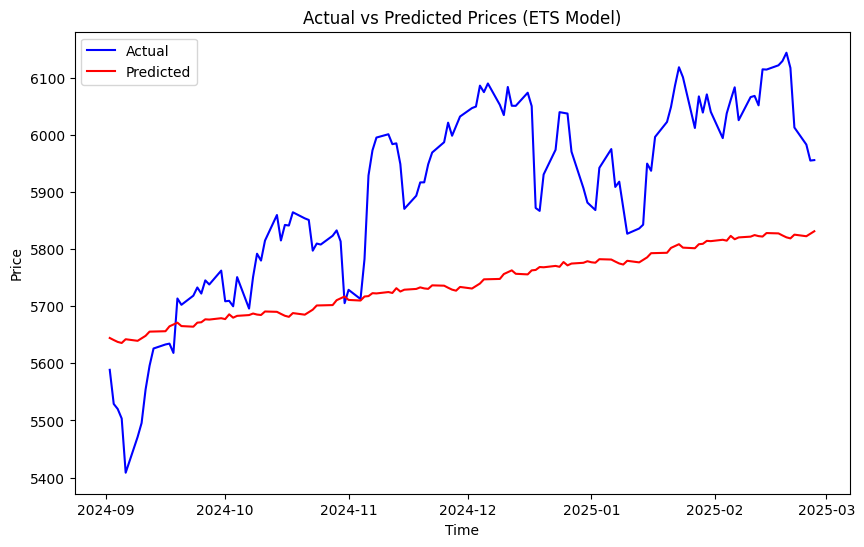

Mean Squared Error (MSE): 39361.4308467687
Mean Absolute Error (MAE): 174.48653719070222
Mean Absolute Percentage Error (MAPE): 2.926194694151799%


In [36]:
# Train ETS model with an additive trend and seasonal component
ets_model = ETSModel(train['Close'], 
                     error="add", trend="add", seasonal="add", 
                     seasonal_periods=30)  # Assuming monthly seasonality

ets_results = ets_model.fit()

# Forecast for the test period
predictions = ets_results.forecast(steps=len(test))

plt.figure(figsize=(10, 6))
plt.plot(test.index, test['Close'], label='Actual', color='blue')
plt.plot(test.index, predictions, label='Predicted', color='red')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs Predicted Prices (ETS Model)')
plt.legend()
plt.show()

# Calculate MSE, MAE, and MAPE
mse = mean_squared_error(test['Close'], predictions)
mae = mean_absolute_error(test['Close'], predictions)
mape = np.mean(np.abs((test['Close'] - predictions) / test['Close'])) * 100

# Show evaluation metrics
print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Absolute Percentage Error (MAPE): {mape}%')

20:14:00 - cmdstanpy - INFO - Chain [1] start processing
20:14:02 - cmdstanpy - INFO - Chain [1] done processing


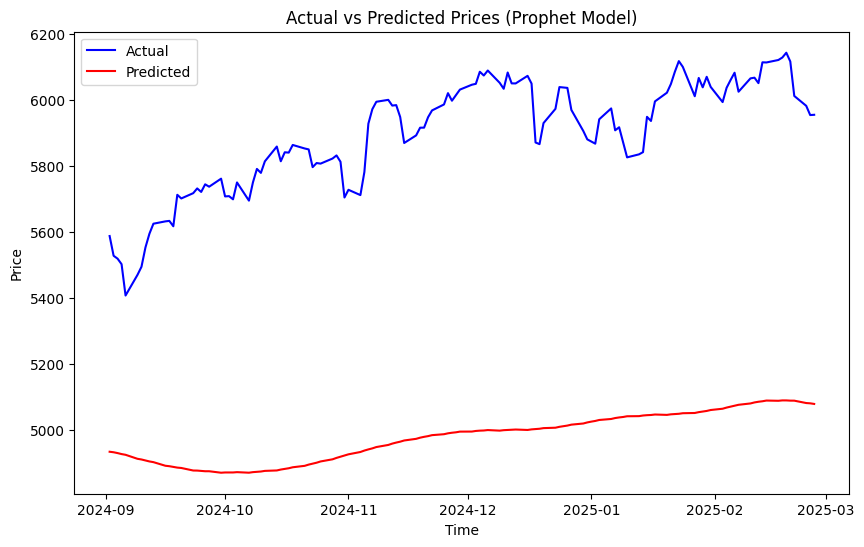

Mean Squared Error (MSE): 853990.9710257323
Mean Absolute Error (MAE): 915.81711849468
Mean Absolute Percentage Error (MAPE): 15.49%


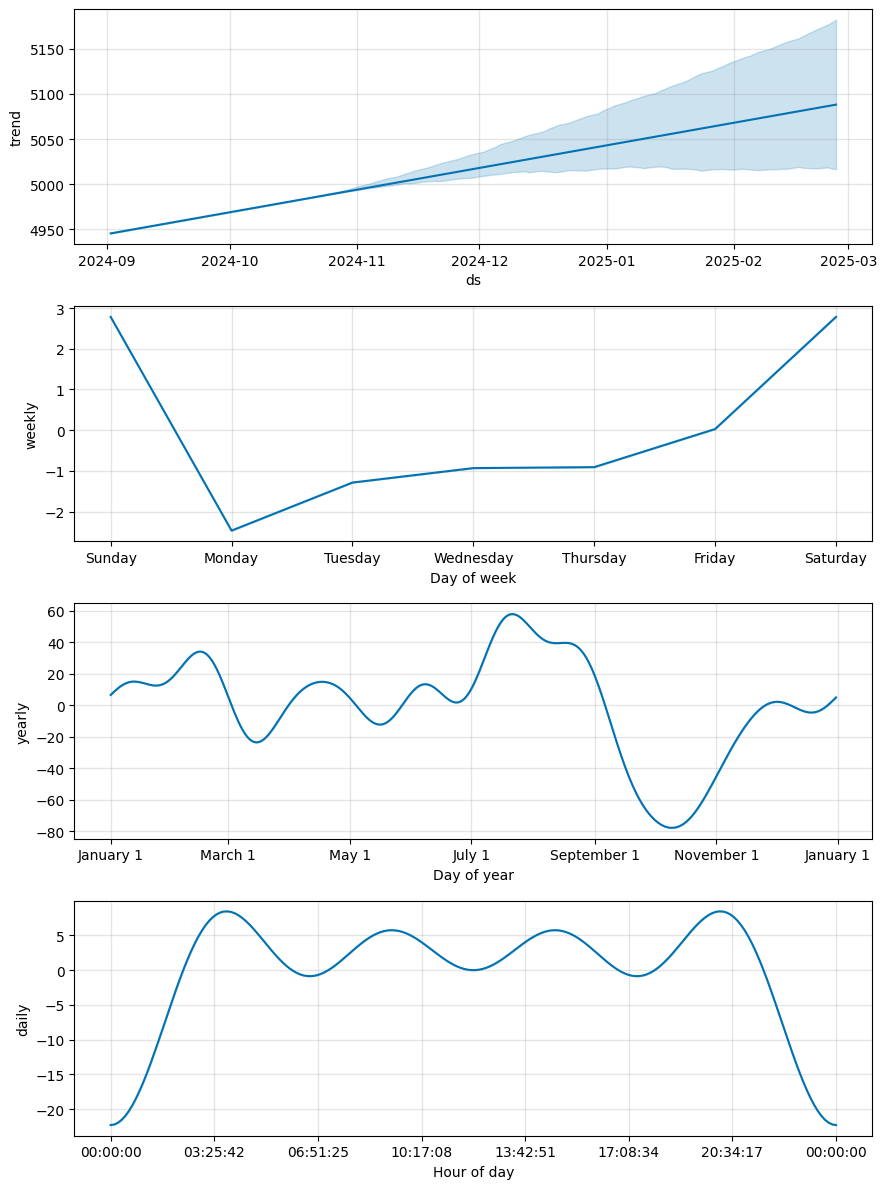

In [ ]:
# Prepare the train data for Prophet
train_prophet = train.reset_index().rename(columns={'index': 'ds'})[['ds', 'Close']]
train_prophet.columns = ['ds', 'y']  # Prophet requires 'ds' and 'y'

# Initialize and fit Prophet model
model = Prophet(daily_seasonality=True,
                weekly_seasonality=True,  # Add weekly seasonality
                yearly_seasonality=True, 
                changepoint_prior_scale=0.2)
model.fit(train_prophet)

# Create future dataframe for prediction (matching test period)
future = pd.DataFrame(test.index, columns=['ds'])
forecast = model.predict(future)

# Extract predictions
predictions = forecast['yhat'].values

# Plot the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(test.index, test['Close'], label='Actual', color='blue')
plt.plot(test.index, predictions, label='Predicted', color='red')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs Predicted Prices (Prophet Model)')
plt.legend()
plt.show()

# Calculate MSE, MAE, and MAPE
mse = mean_squared_error(test['Close'], predictions)
mae = mean_absolute_error(test['Close'], predictions)
mape = np.mean(np.abs((test['Close'] - predictions) / test['Close'])) * 100

# Show evaluation metrics
print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')

# Show model details
model.plot_components(forecast)
plt.show()


20:24:32 - cmdstanpy - INFO - Chain [1] start processing
20:24:34 - cmdstanpy - INFO - Chain [1] done processing


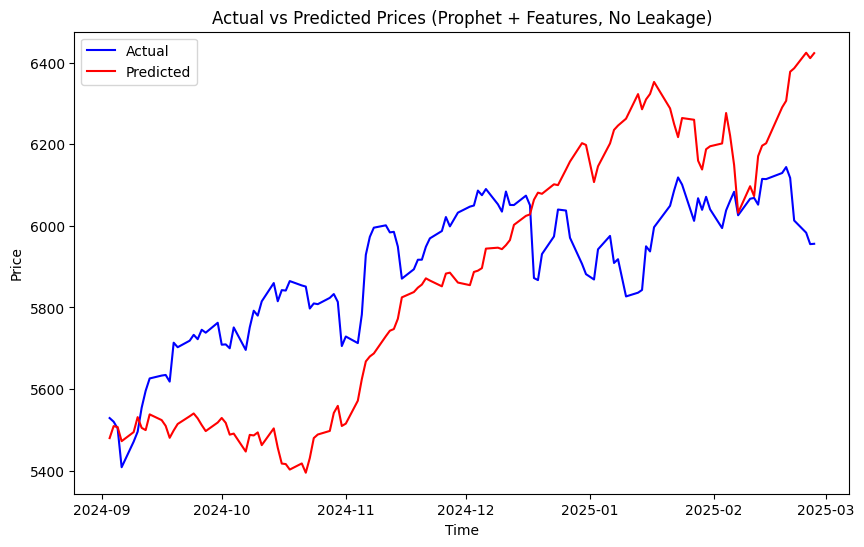

Mean Squared Error (MSE): 56368.58107373281
Mean Absolute Error (MAE): 203.36136802654036
Mean Absolute Percentage Error (MAPE): 3.45%


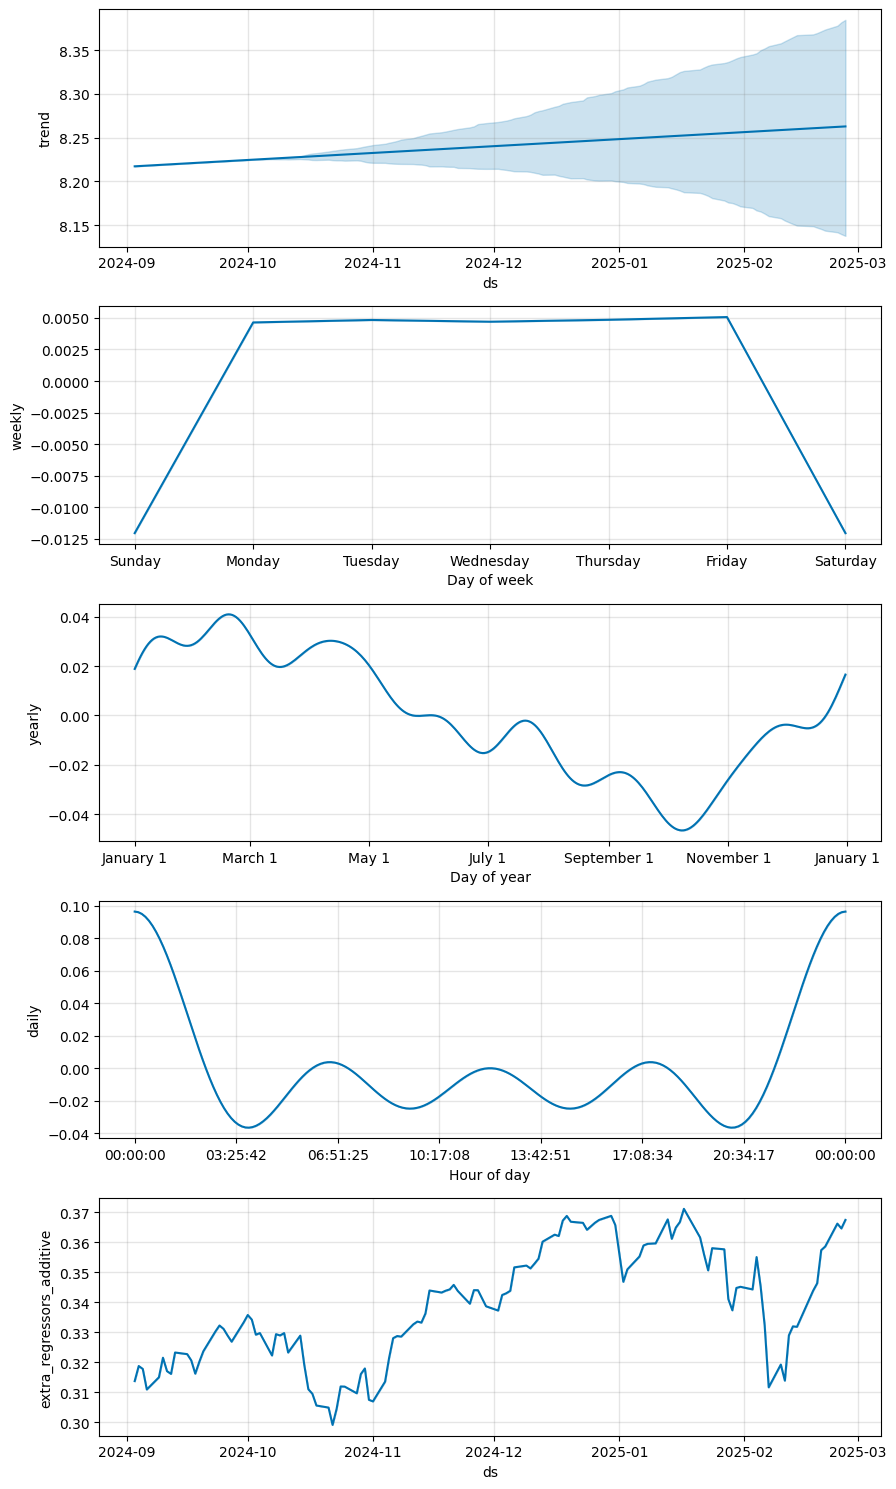

In [52]:
# Compute features using past data only
def create_lagged_features(data, lags):
    for lag in lags:
        data[f'lag_{lag}'] = data['Close'].shift(lag)
    return data

def create_rolling_features(data):
    data['rolling_mean_7'] = data['Close'].rolling(window=7, min_periods=1).mean()
    data['rolling_mean_30'] = data['Close'].rolling(window=30, min_periods=1).mean()
    data['rolling_std_7'] = data['Close'].rolling(window=7, min_periods=1).std()
    data['volatility_7'] = data['Close'].rolling(window=7, min_periods=1).std()
    return data

# Compute RSI
def compute_rsi(data, window=14):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window, min_periods=1).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window, min_periods=1).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

# Compute technical indicators without leaking future data
market_data = create_lagged_features(market_data, lags=[128])
# market_data = create_rolling_features(market_data)
# market_data['RSI'] = compute_rsi(market_data)
market_data['day_of_week'] = market_data.index.dayofweek
market_data['month'] = market_data.index.month

# Drop NA values created by lag features (but keep rolling ones)
market_data = market_data.dropna()

# Split Data
train = market_data[market_data.index < '2024-09-01'].copy()
test = market_data[market_data.index >= '2024-09-01'].copy()

# Ensure test does not use future rolling stats
test = test.copy()
# test['rolling_mean_7'] = pd.concat([train['Close'].iloc[-7:], test['Close']]).rolling(window=7, min_periods=1).mean().iloc[-len(test):]
# test['rolling_mean_30'] = pd.concat([train['Close'].iloc[-30:], test['Close']]).rolling(window=30, min_periods=1).mean().iloc[-len(test):]
# test['rolling_std_7'] = pd.concat([train['Close'].iloc[-7:], test['Close']]).rolling(window=7, min_periods=1).std().iloc[-len(test):]
# test['volatility_7'] = pd.concat([train['Close'].iloc[-7:], test['Close']]).rolling(window=7, min_periods=1).std().iloc[-len(test):]

# Prepare Prophet dataset
train_prophet = train.reset_index().rename(columns={'Date': 'ds'})[['ds', 'Close']]
train_prophet.columns = ['ds', 'y']

# Define extra features
extra_features = ['lag_128', 'day_of_week', 'month']

# Add extra features to Prophet
for feature in extra_features:
    train_prophet[feature] = train[feature].values

# Apply log transformation
train_prophet['y'] = np.log(train_prophet['y'])

# Initialize Prophet with tuned parameters
model = Prophet(
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=True,
    changepoint_prior_scale=0.15  # Slightly reduced to avoid overfitting
)

# Add external regressors
for feature in extra_features:
    model.add_regressor(feature)

# Fit model
model.fit(train_prophet)

# Prepare test dataset without leakage
future = test.reset_index().rename(columns={'Date': 'ds'})[['ds']]
for feature in extra_features:
    future[feature] = test[feature].values

# Predict
forecast = model.predict(future)
predictions = np.exp(forecast['yhat'].values)

# Plot Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.plot(test.index, test['Close'], label='Actual', color='blue')
plt.plot(test.index, predictions, label='Predicted', color='red')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs Predicted Prices (Prophet + Features, No Leakage)')
plt.legend()
plt.show()

# Calculate Metrics
mse = mean_squared_error(test['Close'], predictions)
mae = mean_absolute_error(test['Close'], predictions)
mape = np.mean(np.abs((test['Close'] - predictions) / test['Close'])) * 100

# Show evaluation metrics
print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')

# Show model components
model.plot_components(forecast)
plt.show()


In [51]:
test

,Open,High,Low,Close,Volume,Close_diff,lag_1,lag_3,rolling_mean_7,rolling_mean_30,rolling_std_7,volatility_7,RSI,day_of_week,month,sma_10,sma_50,sma_crossover
Date,,,,,,,,,,,,,,,,,,
2024-09-03,5623.890137,5623.890137,5504.330078,5528.930176,3866350000,-119.469727,5648.399902,5592.180176,5605.531390,5477.104036,39.690766,39.690766,58.447473,1,9,5602.733008,5504.483428,1
2024-09-04,5506.680176,5552.990234,5503.660156,5520.069824,3478140000,-8.860352,5528.930176,5591.959961,5589.168527,5475.915023,48.366758,48.366758,55.924147,2,9,5595.027979,5505.927422,1
2024-09-05,5520.080078,5546.299805,5480.540039,5503.410156,3521650000,-16.659668,5520.069824,5648.399902,5572.964286,5478.457699,55.956552,55.956552,45.818876,3,9,5583.283984,5506.609629,1
2024-09-06,5507.330078,5522.470215,5402.620117,5408.419922,3822800000,-94.990234,5503.410156,5528.930176,5541.910017,5478.764355,77.802631,77.802631,36.980138,4,9,5567.061963,5505.220029,1
2024-09-09,5442.069824,5484.200195,5434.490234,5471.049805,3825940000,62.629883,5408.419922,5520.069824,5524.605678,5479.162679,78.227762,78.227762,37.936518,0,9,5550.705957,5504.983623,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-20,6134.500000,6134.500000,6084.589844,6117.520020,4813690000,-26.629883,6144.149902,6114.629883,6105.917132,6027.175342,33.232269,33.232269,55.766247,3,2,6091.741992,6011.442197,1
2025-02-21,6114.100098,6114.819824,6008.560059,6013.129883,5434560000,-104.390137,6117.520020,6129.580078,6098.007115,6030.645345,47.254198,47.254198,47.119794,4,2,6084.697998,6009.899395,1
2025-02-24,6026.689941,6043.649902,5977.830078,5983.250000,4990120000,-29.879883,6013.129883,6144.149902,6088.189941,6032.812012,62.945633,62.945633,48.768456,0,2,6080.423975,6008.507393,1


In [ ]:
test.head()

In [ ]:
future = prophet_model.make_future_dataframe(periods=128, freq='D')

In [ ]:
future

In [ ]:
train